In [2]:
import re
import os

# 1) 正则表达式

# 解析 epoch summary（训练主循环）
re_epoch = re.compile(
    r"epoch\s+(\d+)\s+summary:\s*"
    r"dyn_dyn_loss\s*:\s*([\d\.Ee+-]+),\s*"
    r"dyn_sta_loss\s*:\s*([\d\.Ee+-]+),\s*"
    r"tot_dyn_loss\s*:\s*([\d\.Ee+-]+),"
)

# train loss / train acc
# 例如：
# train loss: 3.279334, train acc: 0.2651
re_train = re.compile(
    r"train loss:\s*([\d\.Ee+-]+),\s*train acc:\s*([\d\.Ee+-]+)"
)

# valid loss / valid acc
# 例如：
# valid loss: 3.995030, valid acc: 0.1011
re_valid = re.compile(
    r"valid loss:\s*([\d\.Ee+-]+),\s*valid acc:\s*([\d\.Ee+-]+)"
)


# 2) 解析新的文件名结构
def parse_filename(fname):
    """
    解析 N${N}_tp${tp}_Ndynbr${N_dynbr}_ratio0.8.log
    """
    m = re.match(r"N(\d+)_tp(\d+)_Ndynbr(\d+)_ratio0\.8\.log", fname)
    if not m:
        return None
    return {
        "N": int(m.group(1)),
        "tp": int(m.group(2)),
        "N_dynbr": int(m.group(3)),
    }


# 3) 日志解析主函数
def parse_log(path):
    dyn_dyn_list = []
    dyn_sta_list = []
    tot_dyn_list = []

    train_loss_dict = {}   # {epoch: train_loss}
    train_acc_dict  = {}   # {epoch: train_acc}

    valid_loss_list = []   # 用来取 min
    valid_acc_list  = []   # 保存全部 valid acc

    with open(path, "r") as f:
        for line in f:

            # ========== main epoch summary ==========
            m = re_epoch.search(line)
            if m:
                epoch = int(m.group(1))
                dyn_dyn_list.append(float(m.group(2)))
                dyn_sta_list.append(float(m.group(3)))
                tot_dyn_list.append(float(m.group(4)))
                continue

            # ========== train loss / train acc ==========
            m = re_train.search(line)
            if m:
                # train loss 每 10 epoch 出现一次，对应第 k*10 个 epoch
                epoch = len(train_loss_dict) * 10
                train_loss_dict[epoch] = float(m.group(1))
                train_acc_dict[epoch]  = float(m.group(2))
                continue

            # ========== valid loss / valid acc ==========
            m = re_valid.search(line)
            if m:
                valid_loss_list.append(float(m.group(1)))
                valid_acc_list.append(float(m.group(2)))
                continue

    return {
        "dyn_dyn_loss": dyn_dyn_list,
        "dyn_sta_loss": dyn_sta_list,
        "tot_dyn_loss": tot_dyn_list,

        "train_loss": train_loss_dict,   # 每 10 epoch
        "train_acc":  train_acc_dict,    # 每 10 epoch

        "valid_min": min(valid_loss_list) if valid_loss_list else None,
        "valid_acc": max(valid_acc_list) if valid_acc_list else None,
    }


# 4) 加载目录
def load_all_logs(log_dir):
    results = {}

    for fname in os.listdir(log_dir):
        if not fname.endswith(".log"):
            continue

        params = parse_filename(fname)
        if params is None:
            continue

        d = parse_log(os.path.join(log_dir, fname))

        N = params["N"]
        tp = params["tp"]
        Nd = params["N_dynbr"]

        results.setdefault(N, {})
        results[N].setdefault(tp, {})
        results[N][tp][Nd] = d

    return results

results = load_all_logs(".")

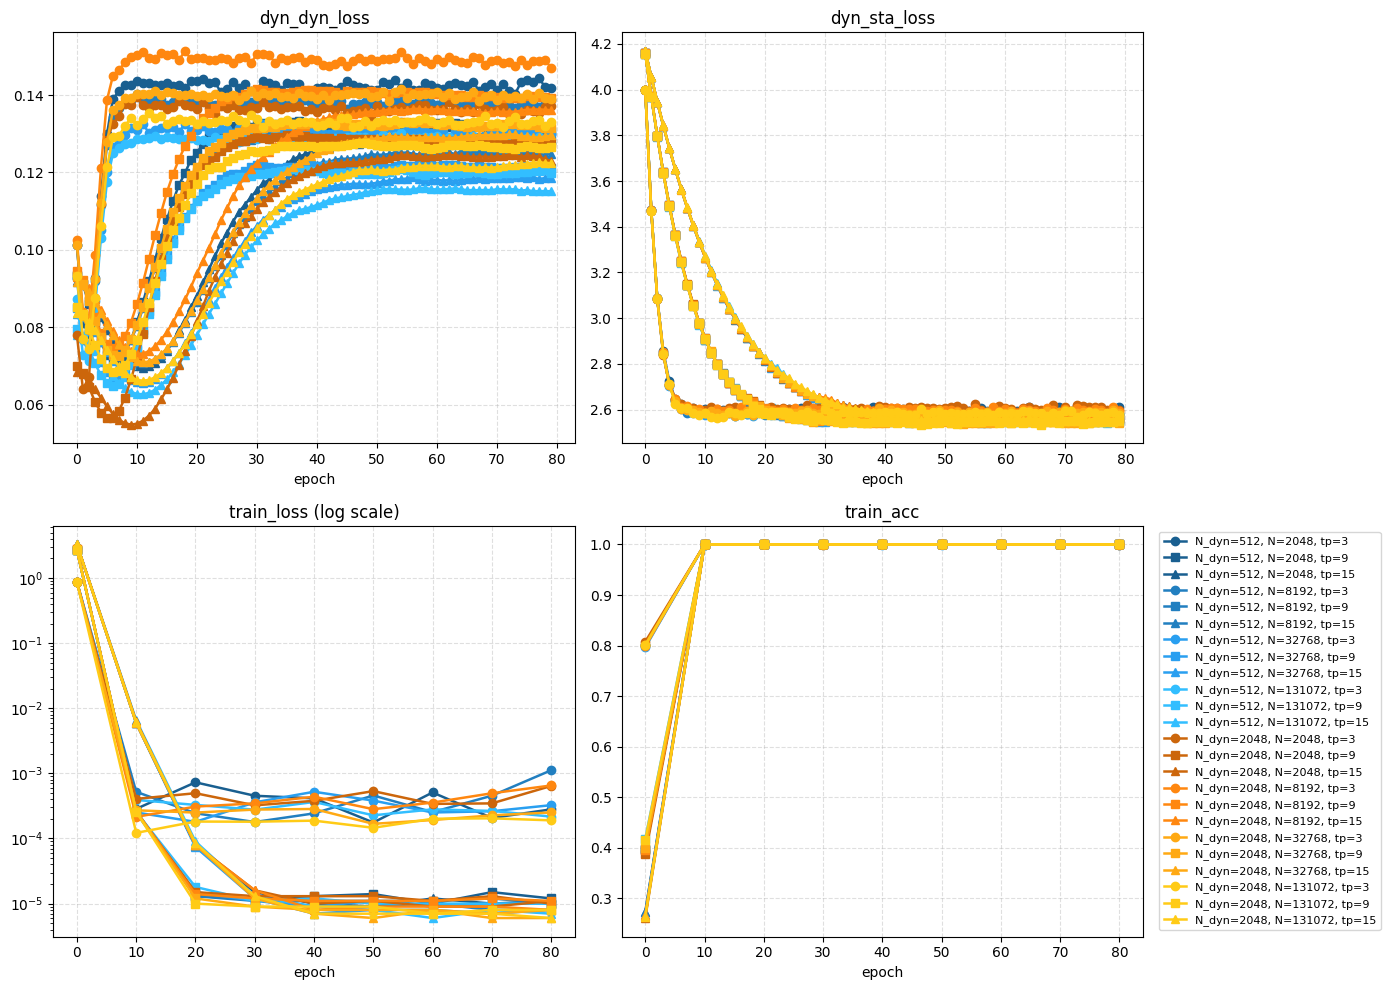

In [3]:
import numpy as np
import matplotlib.pyplot as plt

def adjust_color_depth(color, depth):
    """color: RGBA; depth: 0~1, depth 越大越深"""
    c = color.copy()
    c[:3] *= depth
    return np.clip(c, 0, 1)


def plot_training_curves(results, N_list, N_dynbr_list=None, tp_list=None):
    """
    绘制 2×2 子图：
        (1) dyn_dyn_loss (每 epoch)
        (2) dyn_sta_loss (每 epoch)
        (3) train_loss (log, 每 K epoch)
        (4) train_acc (每 K epoch)

    颜色/标记规则：
      - 不同 N_dynbr → 不同主色
      - 同一 N_dynbr 下，不同 N（小→大）沿主色浅→深
      - 同一 N_dynbr、同一 N 下，不同 tp → 不同 marker
    """

    # ========= 预处理 =========
    if N_dynbr_list is None:
        # 全局收集
        N_dynbr_set = set()
        for N in results:
            for tp in results[N]:
                for Nd in results[N][tp]:
                    N_dynbr_set.add(Nd)
        N_dynbr_list = sorted(N_dynbr_set)

    # 全局 markers
    markers = ["o", "s", "^", "D", "v", "P", "X", "*"]
    tp_to_marker = {tp: markers[i % len(markers)] for i, tp in enumerate(tp_list)}

    # 主色（按 N_dynbr）
    base_cmap = plt.get_cmap("tab10")
    Nd_to_color = {
        Nd: np.array(base_cmap(i % 10))
        for i, Nd in enumerate(N_dynbr_list)
    }

    # ========= 创建 figure =========
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    ax_dyn, ax_sta = axes[0]
    ax_train, ax_acc = axes[1]

    # ========= 主过程：按 N_dynbr → N → tp =========
    for Nd in N_dynbr_list:
        base_color = Nd_to_color[Nd]

        # 对于固定 N_dynbr，计算 N 的深浅顺序
        Ns_sorted = sorted([N for N in N_list if N in results])
        num_N = len(Ns_sorted)

        for idx_N, N in enumerate(Ns_sorted):
            depth = 0.8 + 0.8 * (idx_N / max(1, num_N - 1))  # 浅→深
            color_N = adjust_color_depth(base_color, depth)

            for tp in sorted(results[N].keys()):
                if Nd not in results[N][tp]:
                    continue
                if tp not in tp_list:
                    continue

                stat = results[N][tp][Nd]
                marker = tp_to_marker[tp]
                label = f"N_dyn={Nd}, N={N}, tp={tp}"

                # = dyn_dyn_loss =
                ys = stat["dyn_dyn_loss"]
                if ys:
                    xs = np.arange(len(ys))
                    ax_dyn.plot(xs, ys, color=color_N, marker=marker, linewidth=1.8)

                # = dyn_sta_loss =
                ys = stat["dyn_sta_loss"]
                if ys:
                    xs = np.arange(len(ys))
                    ax_sta.plot(xs, ys, color=color_N, marker=marker, linewidth=1.8)

                # = train_loss =
                tr_dict = stat["train_loss"]
                if tr_dict:
                    xs = sorted(tr_dict.keys())
                    ys = [tr_dict[e] for e in xs]
                    ax_train.plot(xs, ys, color=color_N, marker=marker, linewidth=1.8)

                # = train_acc =
                acc_dict = stat["train_acc"]
                if acc_dict:
                    xs = sorted(acc_dict.keys())
                    ys = [acc_dict[e] for e in xs]
                    ax_acc.plot(xs, ys, color=color_N, marker=marker, linewidth=1.8, label=label)

    # ========= 调整图 =========
    ax_dyn.set_title("dyn_dyn_loss")
    ax_sta.set_title("dyn_sta_loss")
    ax_train.set_title("train_loss (log scale)")
    ax_acc.set_title("train_acc")

    for ax in [ax_dyn, ax_sta, ax_train, ax_acc]:
        ax.set_xlabel("epoch")
        ax.grid(True, linestyle="--", alpha=0.4)

    ax_train.set_yscale("log")

    # legend 放在最右侧
    ax_acc.legend(loc="center left", bbox_to_anchor=(1.02, 0.5), fontsize=8)

    plt.tight_layout()
    plt.show()

plot_training_curves(results, 
                     N_list=[2048, 8192, 32768, 131072], 
                     N_dynbr_list=[512, 2048],
                     tp_list=[3, 9, 15])

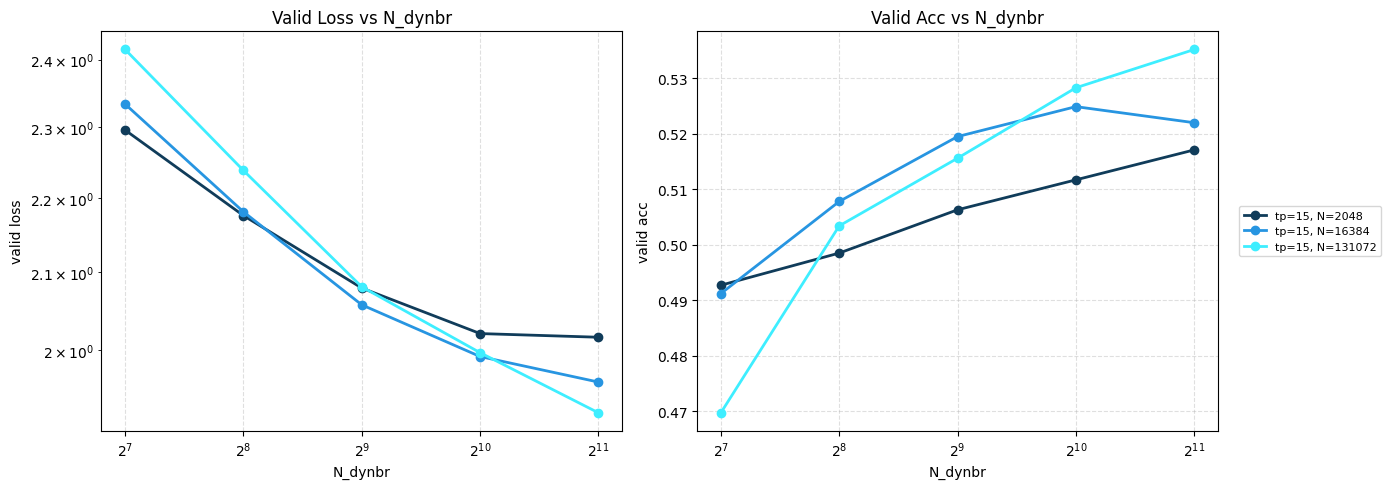

In [23]:
import numpy as np
import matplotlib.pyplot as plt


def adjust_color_depth(color, depth):
    """color: RGBA; depth: 0~1, depth 越大越深"""
    c = color.copy()
    c[:3] *= depth
    return np.clip(c, 0, 1)


def plot_valid_curves(results, N_list, N_dynbr_list=None, tp_list=None):
    """
    生成两张图（左右排列）：
    图1：valid loss vs N_dynbr
    图2：valid acc  vs N_dynbr

    颜色编码：
      - 不同 tp → 不同主色
      - 同一 tp 内：N 小→浅、N 大→深
    """

    # 自动推断 N_dynbr_list
    if N_dynbr_list is None:
        Nd_set = set()
        for N in results:
            for tp in results[N]:
                for Nd in results[N][tp].keys():
                    Nd_set.add(Nd)
        N_dynbr_list = sorted(Nd_set)

    # 自动推断 tp_list
    if tp_list is None:
        tset = set()
        for N in results:
            for tp in results[N]:
                tset.add(tp)
        tp_list = sorted(tset)

    # 主色按 tp
    base_cmap = plt.get_cmap("tab10")
    tp_to_color = {tp: np.array(base_cmap(i % 10))
                   for i, tp in enumerate(tp_list)}

    # N 深浅排序
    Ns_sorted = sorted([N for N in N_list if N in results])
    num_N = len(Ns_sorted)

    # =========== 创建图：左右两个 axis ===========
    fig, ax = plt.subplots(1, 2, figsize=(14, 5), sharey=False)
    ax_loss, ax_acc = ax

    # ----------------------------------------------------------
    # 主循环：tp → N → N_dynbr
    # ----------------------------------------------------------

    for tp in tp_list:
        base_color = tp_to_color[tp]

        for idx_N, N in enumerate(Ns_sorted):
            # N 越大 → 越深
            # print(idx_N, num_N - 1)
            depth = 0.5 + 1.5 * (idx_N / max(1, num_N - 1))
            # print(depth)
            color_N = adjust_color_depth(base_color, depth)

            xs = []  # N_dynbr
            ys_loss = []  # valid loss
            ys_acc = []   # valid acc

            for Nd in N_dynbr_list:
                if N not in results or tp not in results[N] or Nd not in results[N][tp]:
                    continue
                stat = results[N][tp][Nd]

                if stat["valid_min"] is None:
                    continue

                xs.append(Nd)
                ys_loss.append(stat["valid_min"])
                ys_acc.append(stat["valid_acc"])

            # 绘图
            if xs:
                ax_loss.plot(xs, ys_loss, marker="o", linewidth=2,
                             color=color_N,
                             label=f"tp={tp}, N={N}")

                ax_acc.plot(xs, ys_acc, marker="o", linewidth=2,
                            color=color_N,
                            label=f"tp={tp}, N={N}")

    # ----------------------------------------------------------
    # 图形格式
    # ----------------------------------------------------------
    ax_loss.set_title("Valid Loss vs N_dynbr")
    ax_acc.set_title("Valid Acc vs N_dynbr")

    ax_loss.set_xlabel("N_dynbr")
    ax_acc.set_xlabel("N_dynbr")

    ax_loss.set_ylabel("valid loss")
    ax_acc.set_ylabel("valid acc")

    
    # grid
    for axis in [ax_loss, ax_acc]:
        axis.grid(True, linestyle="--", alpha=0.4)

    # legend 放右侧
    ax_acc.legend(loc="center left", bbox_to_anchor=(1.03, 0.5), fontsize=8)

    ax_loss.set_yscale("log")
    ax_loss.set_xscale("log", base=2)
    ax_acc.set_xscale("log", base=2)

    plt.tight_layout()
    plt.show()
plot_valid_curves(results,
                  N_list=[2048, 16384, 131072],
                  N_dynbr_list=[128, 256, 512, 1024, 2048],
                  tp_list=[15])